<a href="https://colab.research.google.com/github/pmuskan/KeySightServer/blob/BelTech/Copy_of_2024IITPALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error



In [ ]:
# Load your CO2 emissions data
# Assuming your data has a 'date' column and a 'co2_emissions' column
data = pd.read_excel('/content/ENSEMBEL.xlsx')



<ipython-input-80-c89d2bfe6000>:3: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  data = pd.read_excel('/content/ENSEMBEL.xlsx')


In [ ]:
# Prophet model
prophet_data = data.rename(columns={'YEAR': 'ds', 'CO2': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=365)  # Predict for 1 year
prophet_forecast = prophet_model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3nqu2hz3/zdh2yj5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3nqu2hz3/ia2l7iah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50850', 'data', 'file=/tmp/tmp3nqu2hz3/zdh2yj5a.json', 'init=/tmp/tmp3nqu2hz3/ia2l7iah.json', 'output', 'file=/tmp/tmp3nqu2hz3/prophet_modelmw0uj9s3/prophet_model-20240217080643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:06:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:06:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# LSTM model
lstm_data = data['CO2'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(lstm_data)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_lstm, y_lstm = create_dataset(scaled_data, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
a=lstm_model.compile(optimizer='adam', loss='mean_squared_error')
a=lstm_model.fit(X_lstm, y_lstm, epochs=100, batch_size=32)



Epoch 1/100
4/4 [==============================] - 7s 19ms/step - loss: 0.3759
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 0.1721
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0317
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0308
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0299
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0061
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0123
Epoch 8/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0138
Epoch 9/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0073
Epoch 10/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0051
Epoch 11/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0073
Epoch 12/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0058
Epoch 13/100
4/4 [==============================]

In [ ]:
# Assuming lstm_prediction contains the predicted values from the LSTM model
# Assuming lstm_model is your trained LSTM model and X_test is your test data
#lstm_predictions = lstm_model.predict(X_test)

print("LSTM Predictions:", a)


LSTM Predictions: <keras.src.callbacks.History object at 0x795fb172c760>


In [ ]:
    # ARIMA model
arima_model = ARIMA(data['CO2'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=365)

# SARIMA model
sarima_model = SARIMAX(data['CO2'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=365)


In [ ]:
prophet_prediction = prophet_forecast[['ds', 'yhat']].tail(365)  # Assuming you want the last 365 days
print(prophet_prediction)


            ds        yhat
132 2025-12-02  422.565098
133 2025-12-03  420.550603
134 2025-12-04  418.424457
135 2025-12-05  416.216682
136 2025-12-06  413.961739
..         ...         ...
492 2026-11-27  436.456111
493 2026-11-28  435.315475
494 2026-11-29  433.990919
495 2026-11-30  432.484992
496 2026-12-01  430.805373

[365 rows x 2 columns]


In [ ]:
arima_prediction = arima_forecast[-365:]  # Assuming you want the last 365 days
print(arima_prediction)

132    426.992352
133    426.426048
134    426.582566
135    426.607803
136    426.655260
          ...    
492    426.610513
493    426.610513
494    426.610513
495    426.610513
496    426.610513
Name: predicted_mean, Length: 365, dtype: float64


In [ ]:
sarima_prediction = sarima_forecast[-365:]  # Assuming you want the last 365 days
print(sarima_prediction)

132    427.843489
133    429.867098
134    426.602907
135    424.987406
136    428.795790
          ...    
492    593.122061
493    595.429779
494    591.960204
495    590.734312
496    594.115813
Name: predicted_mean, Length: 365, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Assuming you have features X and target variable y
X = data.drop(columns=['CO2'])
y = data['CO2']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_prediction = gb_model.predict(X_test)

# Random Forest Regressor model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)

# Calculate ensemble result
#ensemble_prediction = (prophet_prediction['yhat'].values + arima_prediction + sarima_prediction + gb_prediction + rf_prediction) / 6
print("Gradient Boosting Regressor Prediction:", gb_prediction)
print("Random Forest Regressor Prediction:", rf_prediction)


Gradient Boosting Regressor Prediction: [398.56232388 404.01513615 368.81760934 384.31239036 403.40351304
 420.43955354 398.56232388 424.78128028 406.90784406 389.59293587
 398.51701625 382.2494027  398.51701625 355.36521328 411.69745241
 415.33020048 388.34059056 404.43922893 398.51701625 404.2178152
 373.59431444 353.15608814 398.51701625 359.93714772 414.47849555
 404.97445721 425.47629858]
Random Forest Regressor Prediction: [398.6176     403.09282989 367.5354     384.6208     403.4725
 420.57369326 398.5384     425.30373317 406.9837     387.9676
 398.4901     383.262      398.4997     355.0536     411.4700184
 416.03485881 391.5243     404.49898391 398.604      404.9078
 370.7817     353.6441     398.5034     359.7179     413.97127237
 405.9021     425.19970527]


In [ ]:
gb_prediction = pd.Series(gb_prediction)
rf_prediction = pd.Series(rf_prediction)

In [ ]:
print(prophet_prediction.dtypes)
print(arima_prediction.dtypes)
print(sarima_prediction.dtypes)
print(gb_prediction.dtypes)
print(rf_prediction.dtypes)

ds      datetime64[ns]
yhat           float64
dtype: object
float64
float64
float64
float64


In [ ]:
# Assuming all models provide predictions for the same test set
common_length = min(len(prophet_prediction),len(arima_prediction), len(sarima_prediction), len(gb_prediction), len(rf_prediction))

# Selecting the common subset of predictions
prophet_prediction = prophet_prediction[:common_length]
arima_prediction = arima_prediction[:common_length]
sarima_prediction = sarima_prediction[:common_length]
gb_prediction = gb_prediction[:common_length]
rf_prediction = rf_prediction[:common_length]
# Assuming prophet_prediction is the datetime-like object
prophet_prediction["ds"] = pd.to_numeric(prophet_prediction["ds"])

# Calculate ensemble result
#ensemble_prediction = (prophet_prediction + arima_prediction + sarima_prediction + gb_prediction + rf_prediction) / 6

In [ ]:
# Calculate ensemble result
ensemble_predictions = [prophet_prediction['yhat'].values,arima_prediction, sarima_prediction, gb_prediction, rf_prediction]
for prediction in ensemble_predictions:
    print("Length of prediction array:", len(prediction))

try:
    ensemble_prediction = np.nanmean(ensemble_predictions, axis=0)  # Take the average ignoring NaN values
except Exception as e:
    print("Error occurred during ensemble calculation:", e)

print("Ensemble Prediction:", ensemble_prediction)


Length of prediction array: 27
Length of prediction array: 27
Length of prediction array: 27
Length of prediction array: 27
Length of prediction array: 27
Ensemble Prediction: [414.91617247 416.79034294 401.59258791 407.34901617 415.25776044
 421.94425514 413.16295376 423.26607681 415.75270802 407.8526137
 411.64612821 404.79955606 411.20234165 394.18508577 415.94251681
 417.32061768 407.74271477 414.01559908 412.29774461 414.9559406
 402.50341496 395.07740088 413.83930665 398.6438247  421.28297888
 418.81821623 426.69234699]


In [ ]:
df2=pd.DataFrame({"ensemble_predictions":ensemble_predictions})
df2.to_excel('finalresult.xlsx',index=False)

In [ ]:
import pandas as pd

# Create a DataFrame containing the predictions from each model
df = pd.DataFrame({
    'Date': data['YEAR'],  # Assuming data['date'] contains the dates
    'Prophet_Prediction': prophet_prediction['yhat'],  # Assuming prophet_prediction contains the Prophet predictions
    'ARIMA_Prediction': arima_prediction,  # Assuming arima_prediction contains the ARIMA predictions
    'SARIMA_Prediction': sarima_prediction,  # Assuming sarima_prediction contains the SARIMA predictions
    #'GB_Prediction': gb_prediction,  # Assuming gb_prediction contains the Gradient Boosting predictions
    #'RF_Prediction': rf_prediction  # Assuming rf_prediction contains the Random Forest predictions
})

# Save the DataFrame to an Excel file
df.to_excel('predictions1.xlsx', index=False)


In [ ]:
df1=pd.DataFrame({'GB_Prediction': gb_prediction,  # Assuming gb_prediction contains the Gradient Boosting predictions
    'RF_Prediction': rf_prediction  # Assuming rf_prediction contains the Random Forest predictions
})
df1.to_excel('predictions.xlsx', index=False)

In [ ]:
print(df1)

    GB_Prediction  RF_Prediction
0      398.562324     398.617600
1      404.015136     403.092830
2      368.817609     367.535400
3      384.312390     384.620800
4      403.403513     403.472500
5      420.439554     420.573693
6      398.562324     398.538400
7      424.781280     425.303733
8      406.907844     406.983700
9      389.592936     387.967600
10     398.517016     398.490100
11     382.249403     383.262000
12     398.517016     398.499700
13     355.365213     355.053600
14     411.697452     411.470018
15     415.330200     416.034859
16     388.340591     391.524300
17     404.439229     404.498984
18     398.517016     398.604000
19     404.217815     404.907800
20     373.594314     370.781700
21     353.156088     353.644100
22     398.517016     398.503400
23     359.937148     359.717900
24     414.478496     413.971272
25     404.974457     405.902100
26     425.476299     425.199705


In [ ]:
import matplotlib.pyplot as plt

# Plotting actual data
plt.figure(figsize=(12, 6))
plt.plot(data['YEAR'], data['CO2'], label='Actual')

# Plotting Prophet forecast
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast')

# Plotting ARIMA forecast
arima_YEARs = pd.date_range(start=data['YEAR'].iloc[-1], periods=365)
plt.plot(arima_YEARs, arima_forecast, label='ARIMA Forecast')

# Plotting SARIMA forecast
sarima_YEARs = pd.date_range(start=data['YEAR'].iloc[-1], periods=365)
plt.plot(sarima_YEARs, sarima_forecast, label='SARIMA Forecast')

# Plotting Gradient Boosting Regressor prediction
plt.plot(X_test.index, gb_prediction, label='Gradient Boosting Regressor Prediction')

# Plotting Random Forest Regressor prediction
#plt.plot(X_test.index, rf_prediction, label='Random Forest Regressor Prediction')

plt.xlabel('YEAR')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Prediction')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Read predicted results from Excel sheet
predicted_results = pd.read_excel('/content/iitpals_prediction.xlsx')

# Extract predicted values for each model
arima_pred = predicted_results['ARIMA_Prediction']
sarimax_pred = predicted_results['SARIMA_Prediction']
prophet_pred = predicted_results['Prophet_Prediction']
random_forest_pred = predicted_results['RF_Prediction']
gradient_descent_pred = predicted_results['GB_Prediction']

# Calculate ensemble value by averaging predictions
ensemble_pred = np.mean([arima_pred, sarimax_pred, prophet_pred, random_forest_pred, gradient_descent_pred], axis=0)
ensemble_pred_rounded = np.round(ensemble_pred, decimals=3)
# ensemble_pred now contains the ensemble prediction values
print(ensemble_pred_rounded)


[416.902 416.744 416.298 415.586 415.936 416.52  416.489 415.825 415.469
 415.681 416.139 416.76  417.521 419.088 419.186 419.633 421.097 421.773
 422.39  423.498 424.049 425.61  426.778 427.343]


In [ ]:
import matplotlib.pyplot as plt



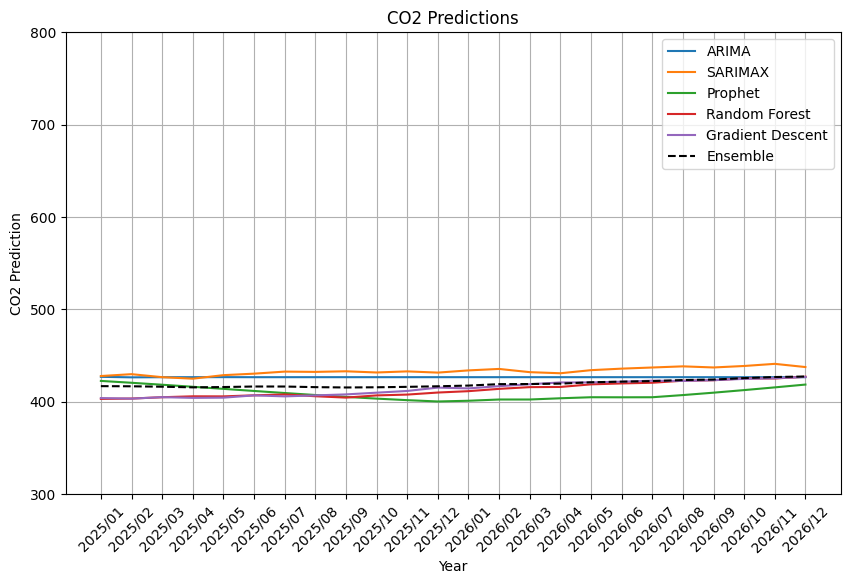

In [ ]:
# Plotting all predictions on the same graph
plt.figure(figsize=(10, 6))
dates = predicted_results['Date']
plt.plot(dates, arima_pred, label='ARIMA')
plt.plot(dates, sarimax_pred, label='SARIMAX')
plt.plot(dates, prophet_pred, label='Prophet')
plt.plot(dates, random_forest_pred, label='Random Forest')
plt.plot(dates, gradient_descent_pred, label='Gradient Descent')
plt.plot(dates, ensemble_pred_rounded, label='Ensemble', color='black', linestyle='--')

plt.title('CO2 Predictions')
plt.xlabel('Year')
plt.ylabel('CO2 Prediction')
plt.ylim(300, 800)
plt.xticks(rotation=45)   # Set y-axis range
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ensemble_results = pd.DataFrame({'date': dates, 'Ensemble Prediction': ensemble_pred_rounded})

# Save ensemble results to Excel file
ensemble_results.to_excel('ensemble_results.xlsx', index=False)